<a href="https://colab.research.google.com/github/Nischay2000/Image_Captioning/blob/main/ImageCaptioningProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!unzip /content/drive/MyDrive/Image_Captioning_Dataset/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr_data/Flickr_Data/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846037553_1a1de50709.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846843520_b0e6211478.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847514745_9a35493023.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847615962_c330bded6e.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848266893_9693c66275.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848571082_26454cb981.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848895544_6d06210e9d.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848977044_446a31d86e.jpg  
  inflating: flickr_data/Flickr_Data/Images/2849194983_2968c72832.jpg  
  inflating: flickr_data/Flickr_Data/Images/2850719435_221f15e951.jpg  
  inflating: 

In [3]:
ls

drive/        Flickr_Data/      sample_data/
flickr_data/  model_weights.h5  train_encoded_images.p


In [4]:
cd Flickr_Data/

/content/Flickr_Data


In [5]:
ls

Flickr_Data/


In [6]:
cd ..

/content


In [7]:
flicker_path = 'Flickr_Data/Flickr_Data/'

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model,load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input,Dense,Dropout,Embedding,LSTM
from keras.layers.merge import add

In [9]:
# this file contain (image and its 5 captions) for every image
with open(flicker_path + "Flickr_TextData/Flickr8k.token.txt") as filepath:
  captions = filepath.read()
  filepath.close()

In [10]:
captions = captions.split("\n")[:-1]

In [11]:
len(captions)

40460

In [12]:
captions[:5]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']

In [13]:
# create a dictionary "descriptions" where key is img_name and value is set captions corresponding to image_file

descriptions = {}
for ele in captions:
  i_to_c  = ele.split("\t")
  img_name = i_to_c[0].split(".")[0]
  cap = i_to_c[1]

  if descriptions.get(img_name) == None:
    descriptions[img_name] = []
  
  descriptions[img_name].append(cap)


In [14]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

**Data Cleaning**


In [15]:
""" 1. lower each word
    2. remove puntuations
    3. remove words less than length 1 """

def clean_text(sample):
  sample = sample.lower()
  sample = re.sub("[^a-z]+"," ",sample)
  sample= sample.split()
  sample = [s for s in sample if len(s)>1]
  sample = " ".join(sample)
  return sample

In [16]:
# modify all captions --> cleaned captions

for key,desc_list in descriptions.items():
  for i in range(len(desc_list)):
    desc_list[i] = clean_text(desc_list[i])

In [17]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [18]:
# writing clean description to .txt file
f = open("descriptions.txt","w")
f.write(str(descriptions))
f.close()

In [19]:
# reading description file

f = open("descriptions.txt","r")
descriptions = f.read()
f.close()

json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [20]:
descriptions

{'1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70': ['black dog and spotted dog are fighting',
  'black dog and tri colored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young girl with p

In [21]:
# there are 40,000 captions
# finding the unique vocabulary
# 8424 are unique words

vocabulary = set()
for key in descriptions.keys():
  [vocabulary.update(i.split()) for i in descriptions[key]]

print('Vocabulary Size : %d' % len(vocabulary))

Vocabulary Size : 8424


In [22]:
# All words in description dictionary
all_vocab = []

for key in descriptions.keys():
  [all_vocab.append(i) for des in descriptions[key] for i in des.split()]

print('Vocabulary Size : %d' % len(all_vocab))
print(all_vocab[:15])

Vocabulary Size : 373837
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl']


In [23]:
# we don't want to take words that occur very rarely in whole text
# count the frequency of each word ,sort them and discard the words having frequency lesser than threshold value

import collections

counter = collections.Counter (all_vocab)
dic_ = dict(counter)

threshold_value = 10

sorted_dic = sorted(dic_.items(),reverse=True,key=lambda x : x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshold_value]
all_vocab = [x[0] for x in sorted_dic]

In [24]:
len(all_vocab)

1845

In [25]:
# setting training and testing set
# train - 6000
# test - 1000

In [26]:
#TrainImageFile
f = open(flicker_path + "Flickr_TextData/Flickr_8k.trainImages.txt")
train = f.read()
f.close()

In [27]:
train

'2513260012_03d33305cf.jpg\n2903617548_d3e38d7f88.jpg\n3338291921_fe7ae0c8f8.jpg\n488416045_1c6d903fe0.jpg\n2644326817_8f45080b87.jpg\n218342358_1755a9cce1.jpg\n2501968935_02f2cd8079.jpg\n2699342860_5288e203ea.jpg\n2638369467_8fc251595b.jpg\n2926786902_815a99a154.jpg\n2851304910_b5721199bc.jpg\n3423802527_94bd2b23b0.jpg\n3356369156_074750c6cc.jpg\n2294598473_40637b5c04.jpg\n1191338263_a4fa073154.jpg\n2380765956_6313d8cae3.jpg\n3197891333_b1b0fd1702.jpg\n3119887967_271a097464.jpg\n2276499757_b44dc6f8ce.jpg\n2506892928_7e79bec613.jpg\n2187222896_c206d63396.jpg\n2826769554_85c90864c9.jpg\n3097196395_ec06075389.jpg\n3603116579_4a28a932e2.jpg\n3339263085_6db9fd0981.jpg\n2532262109_87429a2cae.jpg\n2076906555_c20dc082db.jpg\n2502007071_82a8c639cf.jpg\n3113769557_9edbb8275c.jpg\n3325974730_3ee192e4ff.jpg\n1655781989_b15ab4cbff.jpg\n1662261486_db967930de.jpg\n2410562803_56ec09f41c.jpg\n2469498117_b4543e1460.jpg\n69710415_5c2bfb1058.jpg\n3414734842_beb543f400.jpg\n3006217970_90b42e6b27.jpg\n2192

In [28]:
train = [e.split(".")[0] for e in train.split("\n")[:-1]]

In [29]:
#TestImageFile
f = open(flicker_path + "Flickr_TextData/Flickr_8k.testImages.txt")
test = f.read()
f.close()

In [30]:
test

'3385593926_d3e9c21170.jpg\n2677656448_6b7e7702af.jpg\n311146855_0b65fdb169.jpg\n1258913059_07c613f7ff.jpg\n241347760_d44c8d3a01.jpg\n2654514044_a70a6e2c21.jpg\n2339106348_2df90aa6a9.jpg\n256085101_2c2617c5d0.jpg\n280706862_14c30d734a.jpg\n3072172967_630e9c69d0.jpg\n3482062809_3b694322c4.jpg\n1167669558_87a8a467d6.jpg\n2847615962_c330bded6e.jpg\n3344233740_c010378da7.jpg\n2435685480_a79d42e564.jpg\n3110649716_c17e14670e.jpg\n2511019188_ca71775f2d.jpg\n2521770311_3086ca90de.jpg\n2723477522_d89f5ac62b.jpg\n2218609886_892dcd6915.jpg\n3745451546_fc8ec70cbd.jpg\n2844018783_524b08e5aa.jpg\n3100251515_c68027cc22.jpg\n2207244634_1db1a1890b.jpg\n2943023421_e297f05e11.jpg\n3286822339_5535af6b93.jpg\n2479652566_8f9fac8af5.jpg\n1394368714_3bc7c19969.jpg\n872622575_ba1d3632cc.jpg\n2309860995_c2e2a0feeb.jpg\n241347204_007d83e252.jpg\n3502343542_f9b46688e5.jpg\n757332692_6866ae545c.jpg\n2748729903_3c7c920c4d.jpg\n494792770_2c5f767ac0.jpg\n3213992947_3f3f967a9f.jpg\n2295750198_6d152d7ceb.jpg\n23588980

In [31]:
test = [e.split(".")[0] for e in test.split("\n")[:-1]]

In [32]:
test

['3385593926_d3e9c21170',
 '2677656448_6b7e7702af',
 '311146855_0b65fdb169',
 '1258913059_07c613f7ff',
 '241347760_d44c8d3a01',
 '2654514044_a70a6e2c21',
 '2339106348_2df90aa6a9',
 '256085101_2c2617c5d0',
 '280706862_14c30d734a',
 '3072172967_630e9c69d0',
 '3482062809_3b694322c4',
 '1167669558_87a8a467d6',
 '2847615962_c330bded6e',
 '3344233740_c010378da7',
 '2435685480_a79d42e564',
 '3110649716_c17e14670e',
 '2511019188_ca71775f2d',
 '2521770311_3086ca90de',
 '2723477522_d89f5ac62b',
 '2218609886_892dcd6915',
 '3745451546_fc8ec70cbd',
 '2844018783_524b08e5aa',
 '3100251515_c68027cc22',
 '2207244634_1db1a1890b',
 '2943023421_e297f05e11',
 '3286822339_5535af6b93',
 '2479652566_8f9fac8af5',
 '1394368714_3bc7c19969',
 '872622575_ba1d3632cc',
 '2309860995_c2e2a0feeb',
 '241347204_007d83e252',
 '3502343542_f9b46688e5',
 '757332692_6866ae545c',
 '2748729903_3c7c920c4d',
 '494792770_2c5f767ac0',
 '3213992947_3f3f967a9f',
 '2295750198_6d152d7ceb',
 '2358898017_24496b80e8',
 '3222055946_45f7293

In [33]:
# create train_descriptions dictionary, which will be similar to earlier one, but having only train samples
# add startseq + endseq

train_descriptions = {}
for t in train:
  train_descriptions[t] = []
  for cap in descriptions[t]:
    cap_to_append = "startseq " + cap + " endseq"
    train_descriptions[t].append(cap_to_append)

In [34]:
# mapping description to image
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [35]:
images = flicker_path+"Images/"

In [36]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))

102981632/102967424 [==============================] - 2s 0us/step


In [37]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [38]:
# create new model, by removing the last layer(output layer of 1000 classes from resnet50)
model_new = Model(model.input,model.layers[-2].output)

In [39]:
model_new.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [40]:
#Image Features Extraction using Transfer Learning (ResNet-50 Model)
#Preprocess Image --> Pass through Resnet Model --> Store the encoded features

In [41]:
# converting images to arrays
def preprocess_image(img):
  img = image.load_img(img,target_size=(224,224))
  img = image.img_to_array(img)
  img = np.expand_dims(img,axis=0)
  img = preprocess_input(img)
  return img

In [42]:
def encode_image(img):
  img = preprocess_image(img)
  feature_vector = model_new.predict(img)
  feature_vector = feature_vector.reshape(feature_vector.shape[1],)
  return feature_vector

In [43]:
# encoding each image in train set using resnet
# done using CNN
encoding_train = {}
for ix,img in enumerate(train):
  img = flicker_path+"Images/{}.jpg".format(train[ix])
  encoding_train[img[len(images):]] = encode_image(img)

  if ix%100==0:
    print("Encoding Image - "+ str(ix))

Encoding Image - 0
Encoding Image - 100
Encoding Image - 200
Encoding Image - 300
Encoding Image - 400
Encoding Image - 500
Encoding Image - 600
Encoding Image - 700
Encoding Image - 800
Encoding Image - 900
Encoding Image - 1000
Encoding Image - 1100
Encoding Image - 1200
Encoding Image - 1300
Encoding Image - 1400
Encoding Image - 1500
Encoding Image - 1600
Encoding Image - 1700
Encoding Image - 1800
Encoding Image - 1900
Encoding Image - 2000
Encoding Image - 2100
Encoding Image - 2200
Encoding Image - 2300
Encoding Image - 2400
Encoding Image - 2500
Encoding Image - 2600
Encoding Image - 2700
Encoding Image - 2800
Encoding Image - 2900
Encoding Image - 3000
Encoding Image - 3100
Encoding Image - 3200
Encoding Image - 3300
Encoding Image - 3400
Encoding Image - 3500
Encoding Image - 3600
Encoding Image - 3700
Encoding Image - 3800
Encoding Image - 3900
Encoding Image - 4000
Encoding Image - 4100
Encoding Image - 4200
Encoding Image - 4300
Encoding Image - 4400
Encoding Image - 4500


In [44]:
with open ("./encoded_train_images.pkl","wb") as encoded_pickle:
  pickle.dump(encoding_train,encoded_pickle)

In [45]:
#encoding test images

encoding_test = {}
for ix,img in enumerate(test):
  img = flicker_path+"Images/{}.jpg".format(test[ix])
  encoding_test[img[len(images):]] = encode_image(img)

  if ix%100==0:
    print("Encoding Image - "+ str(ix))


Encoding Image - 0
Encoding Image - 100
Encoding Image - 200
Encoding Image - 300
Encoding Image - 400
Encoding Image - 500
Encoding Image - 600
Encoding Image - 700
Encoding Image - 800
Encoding Image - 900


In [46]:
# save the bottleneck features to disk
with open ("./encoded_test_images.pkl","wb") as encoded_pickle:
  pickle.dump(encoding_test,encoded_pickle)

In [47]:
# load the train images features from disk
with open ("./encoded_train_images.pkl","rb") as encoded_pickle:
  encoding_train = pickle.load(encoded_pickle)


In [48]:
encoding_train['2513260012_03d33305cf.jpg']

array([0.34707907, 0.51159126, 0.08728828, ..., 1.1897281 , 0.04043855,
       0.15271126], dtype=float32)

In [49]:
# load the test images features from disk
with open ("./encoded_test_images.pkl","rb") as encoded_pickle:
  encoding_test = pickle.load(encoded_pickle)

In [50]:
# data processing the captions
# target is to predict captions,this is done by word by word
# first RNN generates one word and then other words are generated by RNN basedon sequence it will be following

# word_to_idx is mapping between each unique word in all_vocab to int value
# and idx_to_word is vice-versa

ix=1
word_to_idx = {}
idx_to_word = {}

for e in all_vocab:
  word_to_idx[e] = ix
  idx_to_word[ix] = e
  ix+=1

In [51]:
word_to_idx['above']

225

In [52]:
idx_to_word[225]

'above'

In [53]:
# unique words
len(word_to_idx)

1845

In [54]:
word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'


In [55]:
# vocab_size is total vocabulary len+1 because we will append 0's as well
vocab_size = len(idx_to_word)+1
print(vocab_size)

1848


In [56]:
# storing length of largest caption
all_captions_len=[]
for key in train_descriptions.keys():
  for cap in train_descriptions[key]:
    all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)

35


In [57]:
# data generator will create sequence of words from an image and these words will be able to what exact caption to be given
# it will create matrix table for each one of the images
# take every caption as batch
# matrix that are genrated will be able to create the btaches
# data generator will help to generate captions according to indexes and words based on image
# for understanding and creating the captions we need data generator

In [58]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,num_photos_per_batch):
  
  X1,X2,y = [],[],[]
  
  n=0

  while True:
    for key,desc_list in train_descriptions.items():
      n += 1

      photo = encoding_train[key+'.jpg']
      for desc in desc_list:
        seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]

        for i in range(1,len(seq)):
          in_seq = seq[0:i]
          out_seq = seq[i]

          in_seq = pad_sequences([in_seq],maxlen=max_len,value=0,padding='post')[0]
          out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]

          X1.append(photo)
          X2.append(in_seq)
          y.append(out_seq)

      if n==num_photos_per_batch:
        yield ([np.array(X1),np.array(X2)],np.array(y))
        
        X1,X2,y = [],[],[]
        n=0

**WORD EMBEDDINGS [Transfer Learning]**

Map the every word (index) to a 50-long vector and for this purpose, we will 
use a pre-trained GLOVE Model

In [59]:
f = open('/content/drive/MyDrive/Image_Captioning_Dataset/glove.6B.50d.txt', encoding='utf8')
f

<_io.TextIOWrapper name='/content/drive/MyDrive/Image_Captioning_Dataset/glove.6B.50d.txt' mode='r' encoding='utf8'>

In [60]:
embedding_index={}
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:],dtype="float")

  embedding_index[word] = coefs

f.close()

In [61]:
# converting words into vectors directly - (Embedding layer output)
def get_embedding_output():

  emb_dim = 50
  embedding_output = np.zeros((vocab_size,emb_dim))

  for word,idx in word_to_idx.items():
    embedding_vector = embedding_index.get(word)

    if embedding_vector is not None:
      embedding_output[idx] = embedding_vector
  
  return embedding_output

embedding_output = get_embedding_output()
embedding_output.shape

(1848, 50)

In [62]:
embedding_output

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.33042 ,  0.24995 , -0.60874 , ..., -0.50703 , -0.027273,
        -0.53285 ],
       [ 0.418   ,  0.24968 , -0.41242 , ..., -0.18411 , -0.11514 ,
        -0.78581 ],
       ...,
       [-0.34126 , -0.06117 ,  0.93339 , ..., -0.5682  , -0.6244  ,
         0.30874 ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

In [63]:
embedding_output.shape

(1848, 50)

**Defining Model**

Since our input consists of two parts,an image vector and a partial caption, we cannot use the Sequential Model, so we create custom


In [64]:
# CNN part 
# image feature extract model, inputs image feature vector
input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [65]:
# CNN part2
#partial caption ssequence model,inputs caption

input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [66]:
# RNN part
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu',)(decoder1)
outputs = Dense(vocab_size,activation="softmax")(decoder2)

In [67]:
# merges 2 networks
model = Model(inputs=[input_img_fea,input_cap],outputs=outputs)

In [68]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [69]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [70]:
model.compile(loss="categorical_crossentropy",optimizer="adam")

In [71]:
epochs=20
number_pics_per_batch=3
steps = len(train_descriptions)//number_pics_per_batch

In [72]:
for i in range(epochs):
  generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,number_pics_per_batch)
  model.fit(generator, epochs = 1 , steps_per_epoch = steps , verbose=1)
  model.save('./model_' + str(i) + '.h5')

   3/2000 [..............................] - ETA: 53s - loss: 3.0974 

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2000/2000 [==============================] - 47s 24ms/step - loss: 2.5567


In [73]:
# taking model from 19th epoch

model = load_model('./model_19.h5')

In [74]:
def predict_caption(photo):
  in_text = "startseq"

  for i in range(max_len):
    sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
    sequence = pad_sequences([sequence],maxlen=max_len,padding='post')

    ypred = model.predict([photo,sequence])
    ypred = ypred.argmax()
    word = idx_to_word[ypred]
    in_text += ' ' + word

    if word=='endseq':
      break
  
  final_caption = in_text.split()
  final_caption = final_caption[1:-1]
  final_caption = ' '.join(final_caption)

  return final_caption

[[1.2118206  0.36763474 0.7385371  ... 2.28133    0.         0.07186344]]


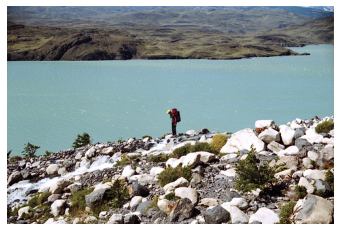

three people are sitting on rocks near the water
[[1.1508958  0.6467048  0.8596071  ... 2.132578   0.00522501 0.02204925]]


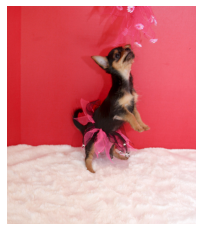

dog is playing with toy in the snow
[[1.3053501  0.8866699  0.29747528 ... 0.03832506 0.13311478 0.2979774 ]]


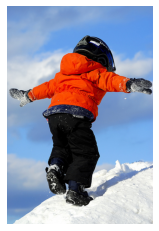

boy in red shirt and red hat is playing with red ball
[[3.0061808  0.25156793 0.30572724 ... 0.29048756 0.0162325  0.26640126]]


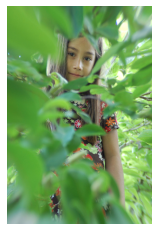

little girl in pink dress is running through the grass
[[0.5577283  0.99426883 0.0484667  ... 0.3458958  0.2790466  0.5216406 ]]


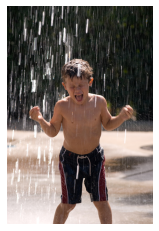

the little girl in the red dress is running on the beach
[[0.26835796 3.7276337  0.4187981  ... 0.30426174 4.178616   0.43360248]]


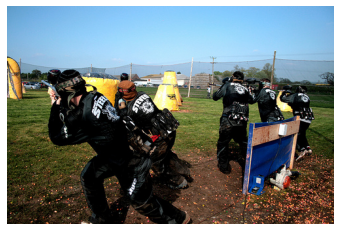

group of people are standing in front of colorful tent
[[0.90580565 1.3772954  0.45607546 ... 0.36170843 1.7774215  0.06874485]]


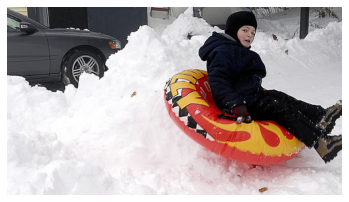

child in red coat plays in the snow
[[0.1453148  0.4310712  0.32506317 ... 0.36835948 0.06922406 0.24358305]]


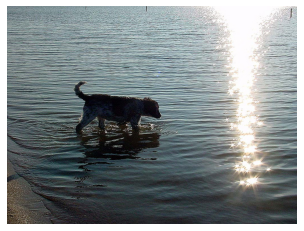

dog is jumping into the water
[[0.05785324 0.7416726  0.8049346  ... 0.         1.8284651  0.07178721]]


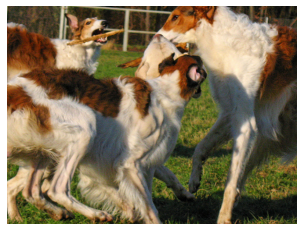

two dogs are playing with toy in the grass
[[0.5800222  0.42343125 0.         ... 0.58796924 0.04485896 0.        ]]


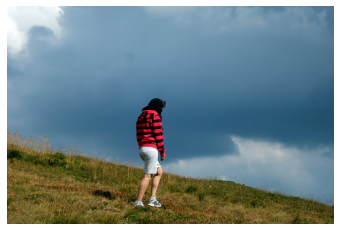

woman in headscarf is sitting on the grass
[[1.0673532  0.51804954 0.02163582 ... 0.3479412  0.07300414 0.04883796]]


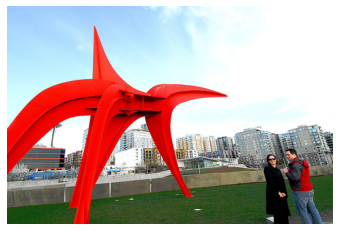

little girl in red shirt is playing in the sprinklers
[[0.09174796 1.8925693  0.62462825 ... 0.2861399  2.8697498  0.8129431 ]]


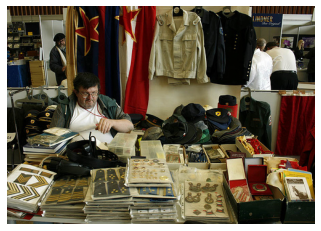

woman in red shirt is standing in front of row
[[0.07246844 0.04885942 0.1542119  ... 0.1930715  1.4442811  0.08791292]]


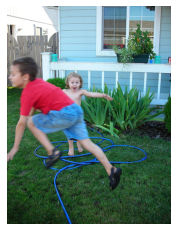

little girl in blue shirt is jumping into the air
[[0.03869765 0.3971384  0.03433248 ... 0.546317   0.03401203 0.6116852 ]]


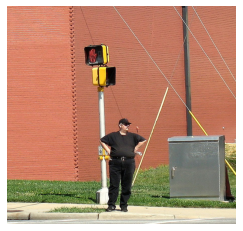

boy in camouflage shirt and white shirt is standing in the midst of the midst of the wall
[[1.1697081  1.4257903  0.         ... 2.8549964  1.122343   0.27590823]]


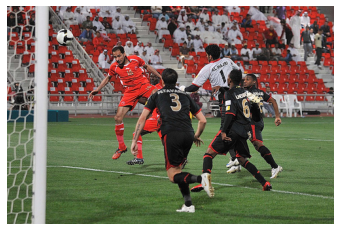

two men are playing soccer
[[0.26049852 0.06255163 0.26739442 ... 0.66803056 0.27725425 0.01250149]]


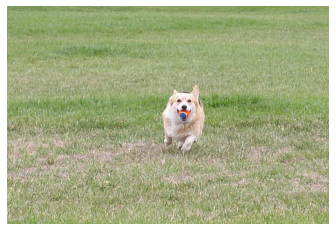

brown dog is running through the grass
[[0.6338316  0.9817179  0.09147453 ... 0.07409291 1.5522144  0.08449669]]


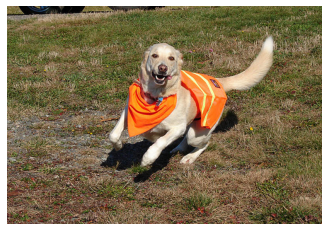

dog with mud toy in its mouth runs through the grass
[[0.24290054 0.27036536 0.17618357 ... 0.11035938 0.10468684 0.46499026]]


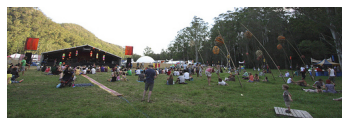

vendor is shown to be driving
[[0.46487045 0.88162595 0.11253179 ... 0.09973355 0.53095114 0.9582255 ]]


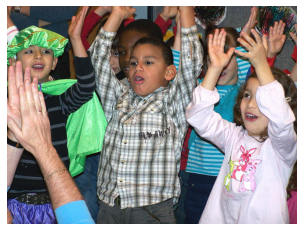

group of children do ready to cover their hands
[[0.7520872  1.6334198  0.1098074  ... 1.5391194  2.631951   0.00319935]]


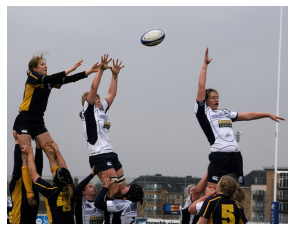

two men attempt to grab the ball


In [76]:
 for i in range(20):
    rn = np.random.randint(0,1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))
    print(photo)
    i = plt.imread(images+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)